In [3]:
from phasic_tonic.detect_phasic import detect_phasic
from phasic_tonic.DatasetLoader import DatasetLoader
from phasic_tonic.helper import get_metadata
from phasic_tonic.runtime_logger import logger_setup    
from phasic_tonic.utils import get_sequences, preprocess

import numpy as np
import pandas as pd
import pynapple as nap

from tqdm.auto import tqdm
from scipy.io import loadmat

fs_cbd = 2500
fs_os = 2500
fs_rgs = 1000

targetFs = 500
n_down_cbd = fs_cbd/targetFs
n_down_rgs = fs_rgs/targetFs
n_down_os = fs_os/targetFs

logger = logger_setup()

CONFIG_DIR = "/home/nero/phasic_tonic/data/dataset_loading.yaml"
OUTPUT_DIR1 = "/home/nero/phasic_tonic/data/analysis_output/whole_posttrial5/"
OUTPUT_DIR2 = "/home/nero/phasic_tonic/data/analysis_output/segmented_posttrial5/"

Datasets = DatasetLoader(CONFIG_DIR)
mapped_datasets = Datasets.load_datasets()

In [2]:
cbd_cnt = 0
rgs_cnt = 0
os_cnt = 0

# Count recordings belonging to CBD dataset
for name in mapped_datasets:
    metadata = get_metadata(name)
    if metadata['treatment'] == 0 or metadata['treatment'] == 1:
        cbd_cnt += 1
    elif metadata['treatment'] == 2 or metadata['treatment'] == 3:
        rgs_cnt += 1
    elif metadata['treatment'] == 4:
        os_cnt += 1

assert cbd_cnt == 170
assert rgs_cnt == 159
assert os_cnt == 210

In [8]:
per_trial_stats = {
    'rat_id': [],
    'study_day': [],
    'condition': [],
    'treatment': [],
    'trial_num': [],
    'state' : [],
    'num_bouts': [],
    'total_duration' : []
}

with tqdm(mapped_datasets) as mapped_tqdm:
    for name in mapped_tqdm:
        metadata = get_metadata(name)
        mapped_tqdm.set_postfix_str(name)
        states_fname, hpc_fname, _ = mapped_datasets[name]
        logger.debug("Loading: {0}".format(name))

        if metadata["treatment"] == 0 or metadata["treatment"] == 1:
            n_down = n_down_cbd
        elif metadata["treatment"] == 2 or metadata["treatment"] == 3:
            n_down = n_down_rgs
        elif metadata["treatment"] == 4:
            n_down = n_down_os
        
        # Load the LFP data
        lfpHPC = loadmat(hpc_fname)['HPC'].flatten()

        # Load the states
        hypno = loadmat(states_fname)['states'].flatten()
        
        # Skip if no REM epoch is detected
        if(not (np.any(hypno == 5))):
            logger.debug("No REM detected. Skipping.")
            continue
        elif(np.sum(np.diff(get_sequences(np.where(hypno == 5)[0]))) < 10):
            logger.debug("No REM longer than 10s. Skipping.")
            continue
        
        # Preprocess
        lfpHPC_down = preprocess(lfpHPC, n_down, targetFs)
        phrem = detect_phasic(lfpHPC_down, hypno, targetFs)

        start, end = [], []
        rem_start, rem_end = [], []
        for rem_idx in phrem:
            rem_start.append(rem_idx[0])
            rem_end.append(rem_idx[1])

            for s, e in phrem[rem_idx]:
                start.append(s / targetFs)
                end.append(e / targetFs)
        
        rem_interval = nap.IntervalSet(rem_start, rem_end)
        phasic_interval = nap.IntervalSet(start, end)
        tonic_interval = rem_interval.set_diff(phasic_interval)
     
        # Save duration bouts
        for state, interval in [("phasic", phasic_interval), ("tonic", tonic_interval)]:
            for condition in metadata.keys():
                per_trial_stats[condition].append(metadata[condition])
            per_trial_stats['state'].append(state)
            per_trial_stats['total_duration'].append(interval.tot_length())
            per_trial_stats['num_bouts'].append(len(interval))

df_trial = pd.DataFrame(per_trial_stats)

  0%|          | 0/539 [00:00<?, ?it/s]

/tmp/ipykernel_37308/523632892.py:54: UserWarning: Some epochs have no duration
  rem_interval = nap.IntervalSet(rem_start, rem_end)
/tmp/ipykernel_37308/523632892.py:55: UserWarning: end is not sorted. Sorting it.
  phasic_interval = nap.IntervalSet(start, end)
/tmp/ipykernel_37308/523632892.py:55: UserWarning: Some ends precede the relative start. Dropping them!
  phasic_interval = nap.IntervalSet(start, end)
/tmp/ipykernel_37308/523632892.py:55: UserWarning: end is not sorted. Sorting it.
  phasic_interval = nap.IntervalSet(start, end)
/tmp/ipykernel_37308/523632892.py:55: UserWarning: Some ends precede the relative start. Dropping them!
  phasic_interval = nap.IntervalSet(start, end)
/tmp/ipykernel_37308/523632892.py:55: UserWarning: end is not sorted. Sorting it.
  phasic_interval = nap.IntervalSet(start, end)
/tmp/ipykernel_37308/523632892.py:55: UserWarning: Some ends precede the relative start. Dropping them!
  phasic_interval = nap.IntervalSet(start, end)
/tmp/ipykernel_37308/

<Axes: xlabel='trial_num', ylabel='total_duration'>

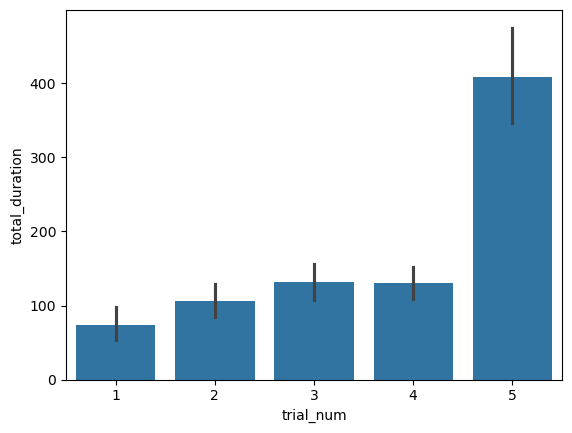

In [3]:
import pandas as pd
import seaborn as sns

df = pd.read_csv("/home/nero/phasic_tonic/data/analysis_output/whole_posttrial5/phasic_tonic_per_rem_trials.csv")
sns.barplot(data=df, x='trial_num', y='total_duration')

In [10]:
df_trial.to_csv(OUTPUT_DIR1+"phasic_tonic_per_rem_trials.csv", index=False)